## PART 1: EDA
1.Read Data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')

df = pd.read_csv('HomeC-meter1_2014.csv',sep=',', header='infer', parse_dates=[0])
print("Fields in the dataset:\n",list(df.columns))

Fields in the dataset:
 ['Time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1', 'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door', 'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave', 'Livingroom', 'Solar']


2.Compute the daily load curve

In [2]:
df['Hour'] = df.Time.dt.hour
df['Day'] = df.Time.dt.dayofyear
df['DayOfWeek'] = df.Time.dt.dayofweek
df = df.groupby(['Day', 'Hour']).mean().unstack().interpolate(method='linear')

3.Total Demands and Normalized Load Curve

In [3]:
apps = np.array(['Dishwasher', 'Furnace 1', 'Furnace 2', 'Home office', 'Fridge', 
        'Wine cellar', 'Garage door', 'Kitchen 12', 'Kitchen 14', 'Kitchen 38',
        'Barn', 'Well', 'Microwave', 'Livingroom', 'Solar'])

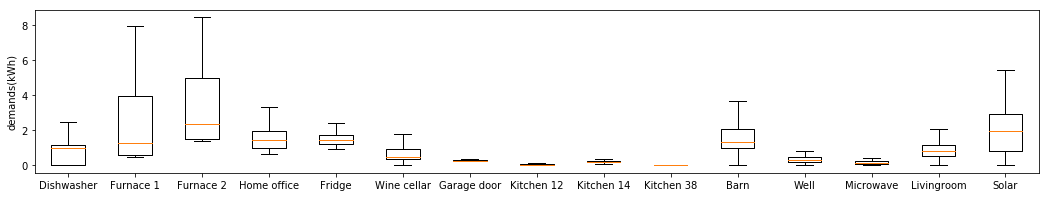

In [4]:
total_demands = []
mean_power = {}
for app in apps:
    temp = np.array(df[app]).sum(axis=1)
    total_demands.append(temp)
    mean_power.update({app: temp.mean()})
plt.figure(figsize=(18,3))
plt.ylabel("demands(kWh)")
plt.boxplot(total_demands,0,'')
plt.xticks(range(1,len(apps)+1), apps)
plt.show()

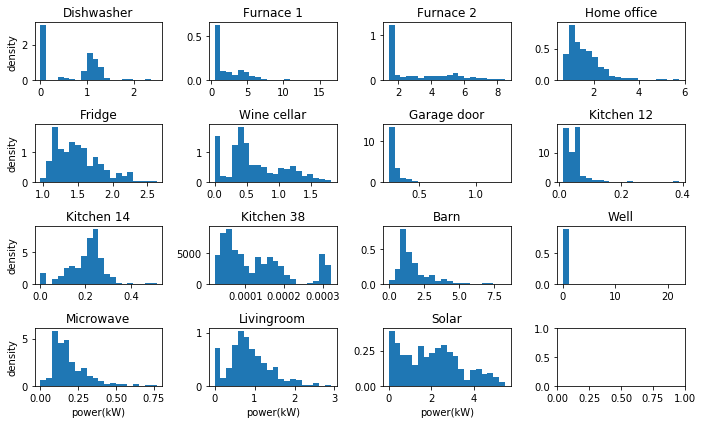

In [5]:
fig = plt.figure(figsize=(10,6))
axes = fig.subplots(nrows=4,ncols=4)
for i, app in enumerate(apps):
    plt.sca(axes[int(i/4)][i%4])
    plt.hist(total_demands[i], bins=20, normed=True)
    plt.title(app)
    if (i%4==0):
        plt.ylabel("density")
    if (i>=12):
        plt.xlabel("power(kW)")

plt.tight_layout()
plt.show()

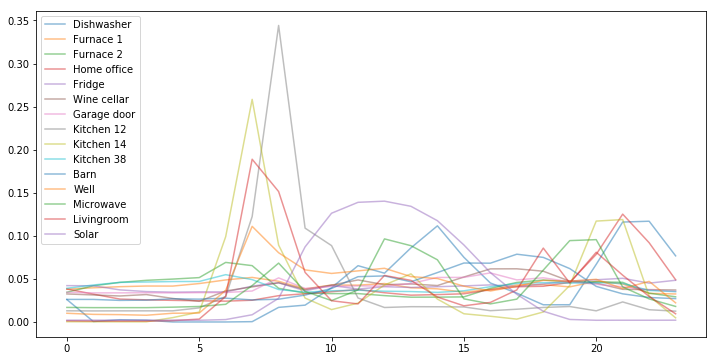

In [6]:
data = []
plt.figure(figsize=(12,6))
for app in apps:
    temp = np.array(df[app])
    temp = temp.mean(axis=0)
    temp = temp / temp.sum()
    plt.plot(temp, label=app, alpha=0.5)
    data.append(temp)
data = np.array(data)
plt.legend(loc='best')
plt.show()

4.Clustering(by averaging or voting)

group#0: ['Dishwasher' 'Furnace 1' 'Furnace 2' 'Home office' 'Fridge' 'Wine cellar'
 'Garage door' 'Kitchen 38' 'Barn' 'Well' 'Microwave']
group#1: ['Solar']
group#2: ['Kitchen 12']
group#3: ['Kitchen 14' 'Livingroom']


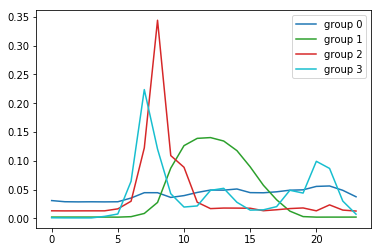

In [7]:
from sklearn.cluster import KMeans

clrs = ['tab:blue','tab:green','tab:red','tab:cyan']

K=4
kmeans = KMeans(n_clusters=K).fit(data)
y = kmeans.labels_
c = kmeans.cluster_centers_
for i in range(K):
    plt.plot(c[i], label='group %d'%i, color=clrs[i])
    print('group#%d: %s'%(i, str(apps[y==i])))
plt.legend(loc='best')
plt.show()

In [8]:
data = np.array([])
gt = np.array([])
for i,app in enumerate(apps):
    temp = np.array(df[app])
    temp = temp / temp.sum(axis=1).reshape(-1,1)
    index = np.where(np.isnan(temp).sum(axis=1)==0)[0]
    temp = temp[index,:]
    yt = np.ones((temp.shape[0],1),dtype=int)*i
    if len(data):
        data = np.concatenate([data, temp], axis=0)
        gt = np.concatenate([gt, yt], axis=0)
    else:
        data = temp.copy()
        gt = yt.copy()

group#0: ['Solar']
group#1: ['Kitchen 14' 'Well' 'Livingroom']
group#2: []
group#3: ['Dishwasher' 'Furnace 1' 'Furnace 2' 'Home office' 'Fridge' 'Wine cellar'
 'Garage door' 'Kitchen 12' 'Kitchen 38' 'Barn' 'Microwave']
group#4: []


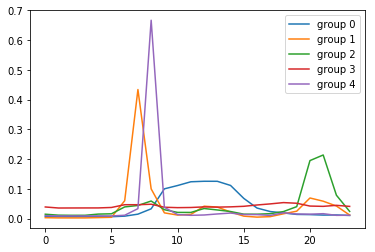

In [9]:
K=5
kmeans = KMeans(n_clusters=K).fit(data)
l = kmeans.labels_
c = kmeans.cluster_centers_

Y = []
for i in range(gt.max()+1):
    temp = l[np.where(gt==i)[0]]
    Y.append([(temp == j).sum() for j in range(K)])
Y=np.array(Y)
y=Y.argmax(axis=1)
for i in range(K):
    plt.plot(c[i], label='group %d'%i)
    print('group#%d: %s'%(i, str(apps[y==i])))
plt.legend(loc='best')
plt.show()

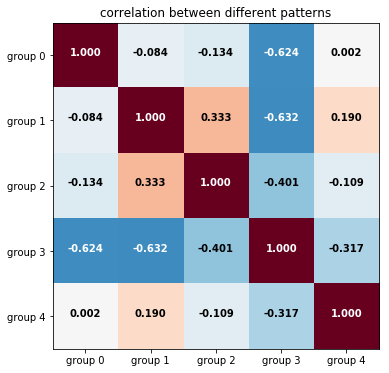

In [10]:
corr = np.corrcoef(Y.T)
plt.figure(figsize=(6,6))
plt.imshow(corr, interpolation='nearest',cmap=plt.cm.RdBu_r,vmin=-1,vmax=1)
plt.title("correlation between different patterns")
plt.xticks(range(5), ['group %d'%i for i in range(5)])
plt.yticks(range(5), ['group %d'%i for i in range(5)])

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, format(corr[i, j], '.3f'), weight='bold',
                 horizontalalignment="center",
                 color="white" if np.abs(corr[i, j]) > 0.5 else "black")
plt.show()

## PART 2: Temperature Related

In [11]:
dft = pd.read_csv('homeC2014.csv',sep=',', header='infer', parse_dates=[9])[['humidity','windSpeed','apparentTemperature','temperature']]

In [12]:
print(dft.head(5))

   humidity  windSpeed  apparentTemperature  temperature
0      0.47      13.21                 7.41        20.28
1      0.48      10.07                 7.91        19.28
2      0.52       8.43                 7.90        18.35
3      0.55       7.90                 7.47        17.67
4      0.60       5.81                 7.42        16.04


In [13]:
# temp = np.array(dft.temperature).reshape(365,24)
# for app in apps:
#     demands = np.array(df[app])
# #     demands = demands / demands.sum(axis=1).reshape(-1,1)
#     lr = LinearRegression().fit(temp, demands)
#     coef = lr.coef_
#     print(app)
#     plt.imshow(coef)
#     plt.colorbar()
#     plt.show()
#     #break

In [14]:
from sklearn.linear_model import LinearRegression
temp = np.array(dft.temperature).reshape(-1,1)
norm_coef = [[],[]]
pred1 = []
for app in apps:
    demands = np.array(df[app]).reshape(-1,1)
    lr = LinearRegression().fit(temp, demands)
    coef = lr.coef_[0][0]
    bias = lr.intercept_
    ncoef = coef/mean_power[app]
    norm_coef[0].append(ncoef)
    pred1.append(lr.predict(temp))
    print(app+" "*(15-len(app))+"%8.4f "%(ncoef)+"%8.4f kW/F"%(coef)+" * T + %8.4f kW"%(bias))

Dishwasher       0.0001   0.0000 kW/F * T +   0.0277 kW
Furnace 1       -0.0017  -0.0041 kW/F * T +   0.2959 kW
Furnace 2       -0.0012  -0.0040 kW/F * T +   0.3293 kW
Home office      0.0001   0.0002 kW/F * T +   0.0566 kW
Fridge           0.0003   0.0004 kW/F * T +   0.0423 kW
Wine cellar      0.0010   0.0006 kW/F * T +  -0.0049 kW
Garage door      0.0001   0.0000 kW/F * T +   0.0103 kW
Kitchen 12      -0.0006  -0.0000 kW/F * T +   0.0033 kW
Kitchen 14      -0.0004  -0.0001 kW/F * T +   0.0120 kW
Kitchen 38      -0.0002  -0.0000 kW/F * T +   0.0000 kW
Barn             0.0004   0.0006 kW/F * T +   0.0431 kW
Well             0.0003   0.0001 kW/F * T +   0.0110 kW
Microwave       -0.0000  -0.0000 kW/F * T +   0.0083 kW
Livingroom      -0.0003  -0.0002 kW/F * T +   0.0469 kW
Solar            0.0012   0.0025 kW/F * T +  -0.0337 kW


In [15]:
temp = np.array(dft.apparentTemperature).reshape(-1,1)
pred2=[]
for app in apps:
    demands = np.array(df[app]).reshape(-1,1)
    lr = LinearRegression().fit(temp, demands)
    coef = lr.coef_[0][0]
    bias = lr.intercept_
    ncoef = coef/mean_power[app]
    norm_coef[1].append(ncoef)
    pred2.append(lr.predict(temp))
    print(app+" "*(15-len(app))+"%8.4f "%(ncoef)+"%8.4f kW/F"%(coef)+" * T + %8.4f kW"%(bias))

Dishwasher       0.0000   0.0000 kW/F * T +   0.0286 kW
Furnace 1       -0.0015  -0.0036 kW/F * T +   0.2630 kW
Furnace 2       -0.0011  -0.0035 kW/F * T +   0.2940 kW
Home office      0.0001   0.0002 kW/F * T +   0.0589 kW
Fridge           0.0002   0.0004 kW/F * T +   0.0465 kW
Wine cellar      0.0009   0.0005 kW/F * T +   0.0016 kW
Garage door      0.0001   0.0000 kW/F * T +   0.0107 kW
Kitchen 12      -0.0005  -0.0000 kW/F * T +   0.0031 kW
Kitchen 14      -0.0003  -0.0001 kW/F * T +   0.0112 kW
Kitchen 38      -0.0002  -0.0000 kW/F * T +   0.0000 kW
Barn             0.0003   0.0005 kW/F * T +   0.0510 kW
Well             0.0003   0.0001 kW/F * T +   0.0128 kW
Microwave       -0.0001  -0.0000 kW/F * T +   0.0084 kW
Livingroom      -0.0002  -0.0002 kW/F * T +   0.0451 kW
Solar            0.0010   0.0020 kW/F * T +  -0.0052 kW


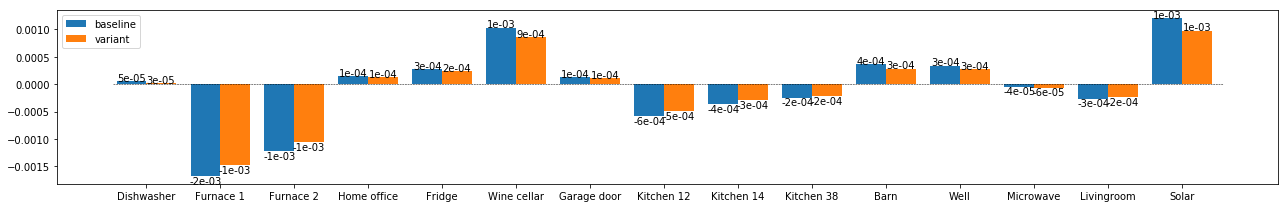

In [16]:
plt.figure(figsize=(18,3))
plt.bar(np.arange(0,30,2),norm_coef[0],label='baseline')
for i,c in enumerate(norm_coef[0]):
    if (c>0):
        plt.text(2*i,c,"%.0e"%c, horizontalalignment='center')
    else:
        plt.text(2*i,c,"%.0e"%c, horizontalalignment='center',verticalalignment='top')
        
plt.bar(np.arange(0.8,30,2),norm_coef[1],label='variant')
for i,c in enumerate(norm_coef[1]):
    if (c>0):
        plt.text(2*i+0.8,c,"%.0e"%c, horizontalalignment='center')
    else:
        plt.text(2*i+0.8,c,"%.0e"%c, horizontalalignment='center',verticalalignment='top')

plt.plot([-0.5,29.5],[0,0],'k--',lw=0.5)
plt.xticks(np.arange(0.4,30,2),apps)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

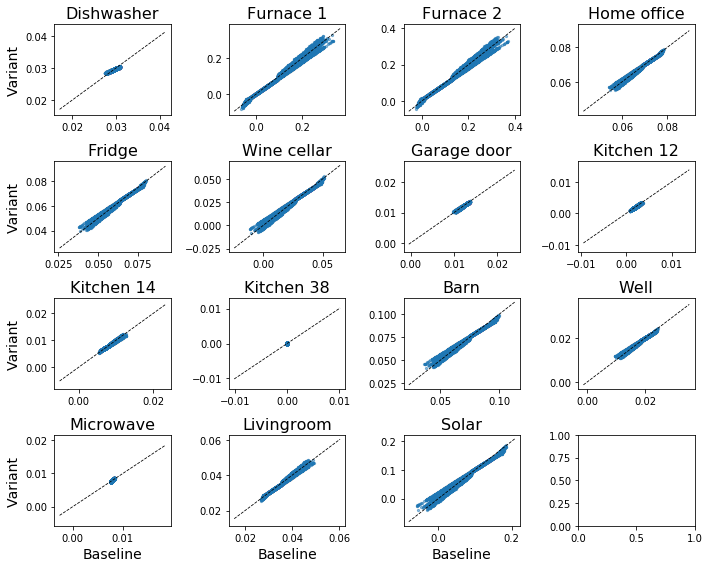

In [17]:
fig = plt.figure(figsize=(10,8))
axes = fig.subplots(nrows=4,ncols=4)
for i, app in enumerate(apps):
    plt.sca(axes[int(i/4)][i%4])
    plt.scatter(pred1[i],pred2[i],s=5,alpha=0.5)
    mn,mx = plt.gca().get_xlim()
    plt.plot([mn,mx],[mn,mx],'k--',lw=0.8)
    plt.title(app,fontsize=16)
    if (i%4==0):
        plt.ylabel("Variant",fontsize=14)
    if (i>=12):
        plt.xlabel("Baseline",fontsize=14)

plt.tight_layout()
plt.show()